In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from src.config import BaseConfig

config = BaseConfig()
vs = {"renderer": "png", "width": 1000, "height": 500, "scale": 3}

In [2]:
final_data = pd.read_json(config.processed_data_dir / "final_data_to_train.json")
data = pd.read_json(config.interim_data_dir / "cleaned_enriched_jira_tasks.json")

In [3]:
data["jira_created"] = pd.to_datetime(data["jira_created"])

data.head(0)

,assignee_email,assignee_level_order,jira_created,jira_description,jira_key,jira_title,slack_link,time_to_complete_hours,weeks_since_member_join,slack_thread_messages


# <b>Overview of the data

In [4]:
data["assignee_email"] = data.assignee_email.apply(lambda _x: f"{str(abs(hash(_x)))[:4]}@hashed-mail.com")

Most tasks were resolved within 2 hours. The most common time values for task completion are 1, 2, 4, 8, and 16 hours, which reflect the planning and estimation process.

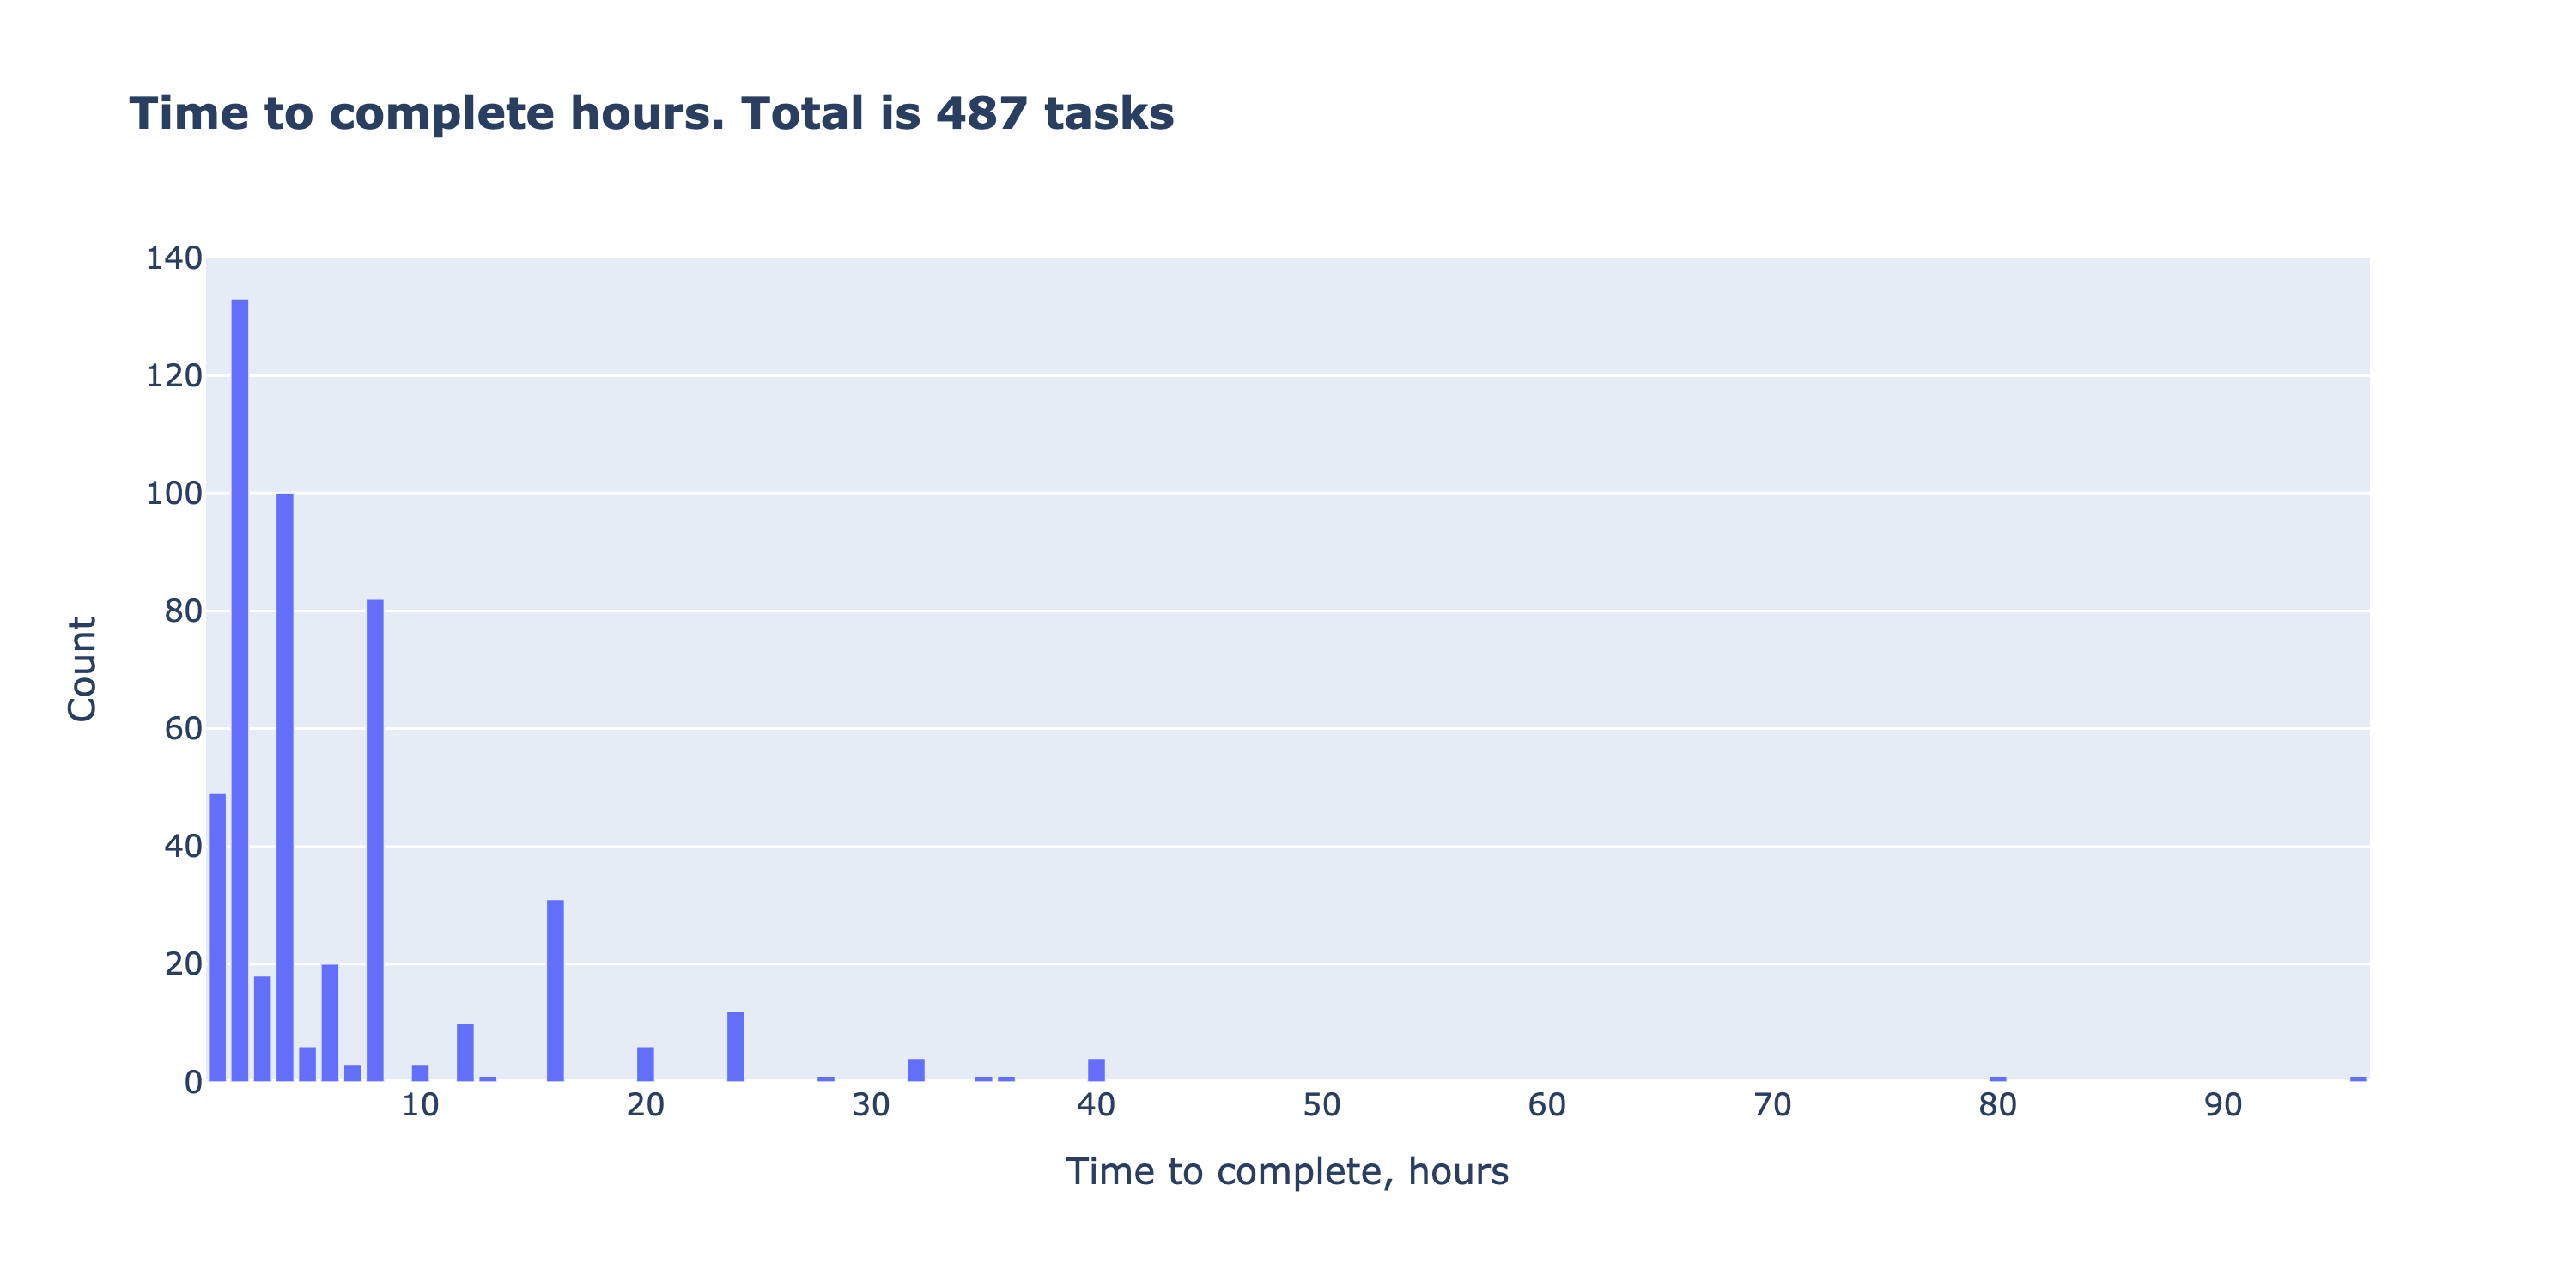

In [5]:
px.bar(
    final_data.time_to_complete_hours.value_counts().reset_index(),
    x="time_to_complete_hours",
    y="count",
    title=f"<b>Time to complete hours. Total is {final_data.shape[0]} tasks</b>",
    labels={"time_to_complete_hours": "Time to complete, hours", "count": "Count"},
).show(**vs)

This chart highlights trends that strongly correlate with team members' feedback about workload. Members with higher experience and longer tenure in the team tend to handle more tasks.

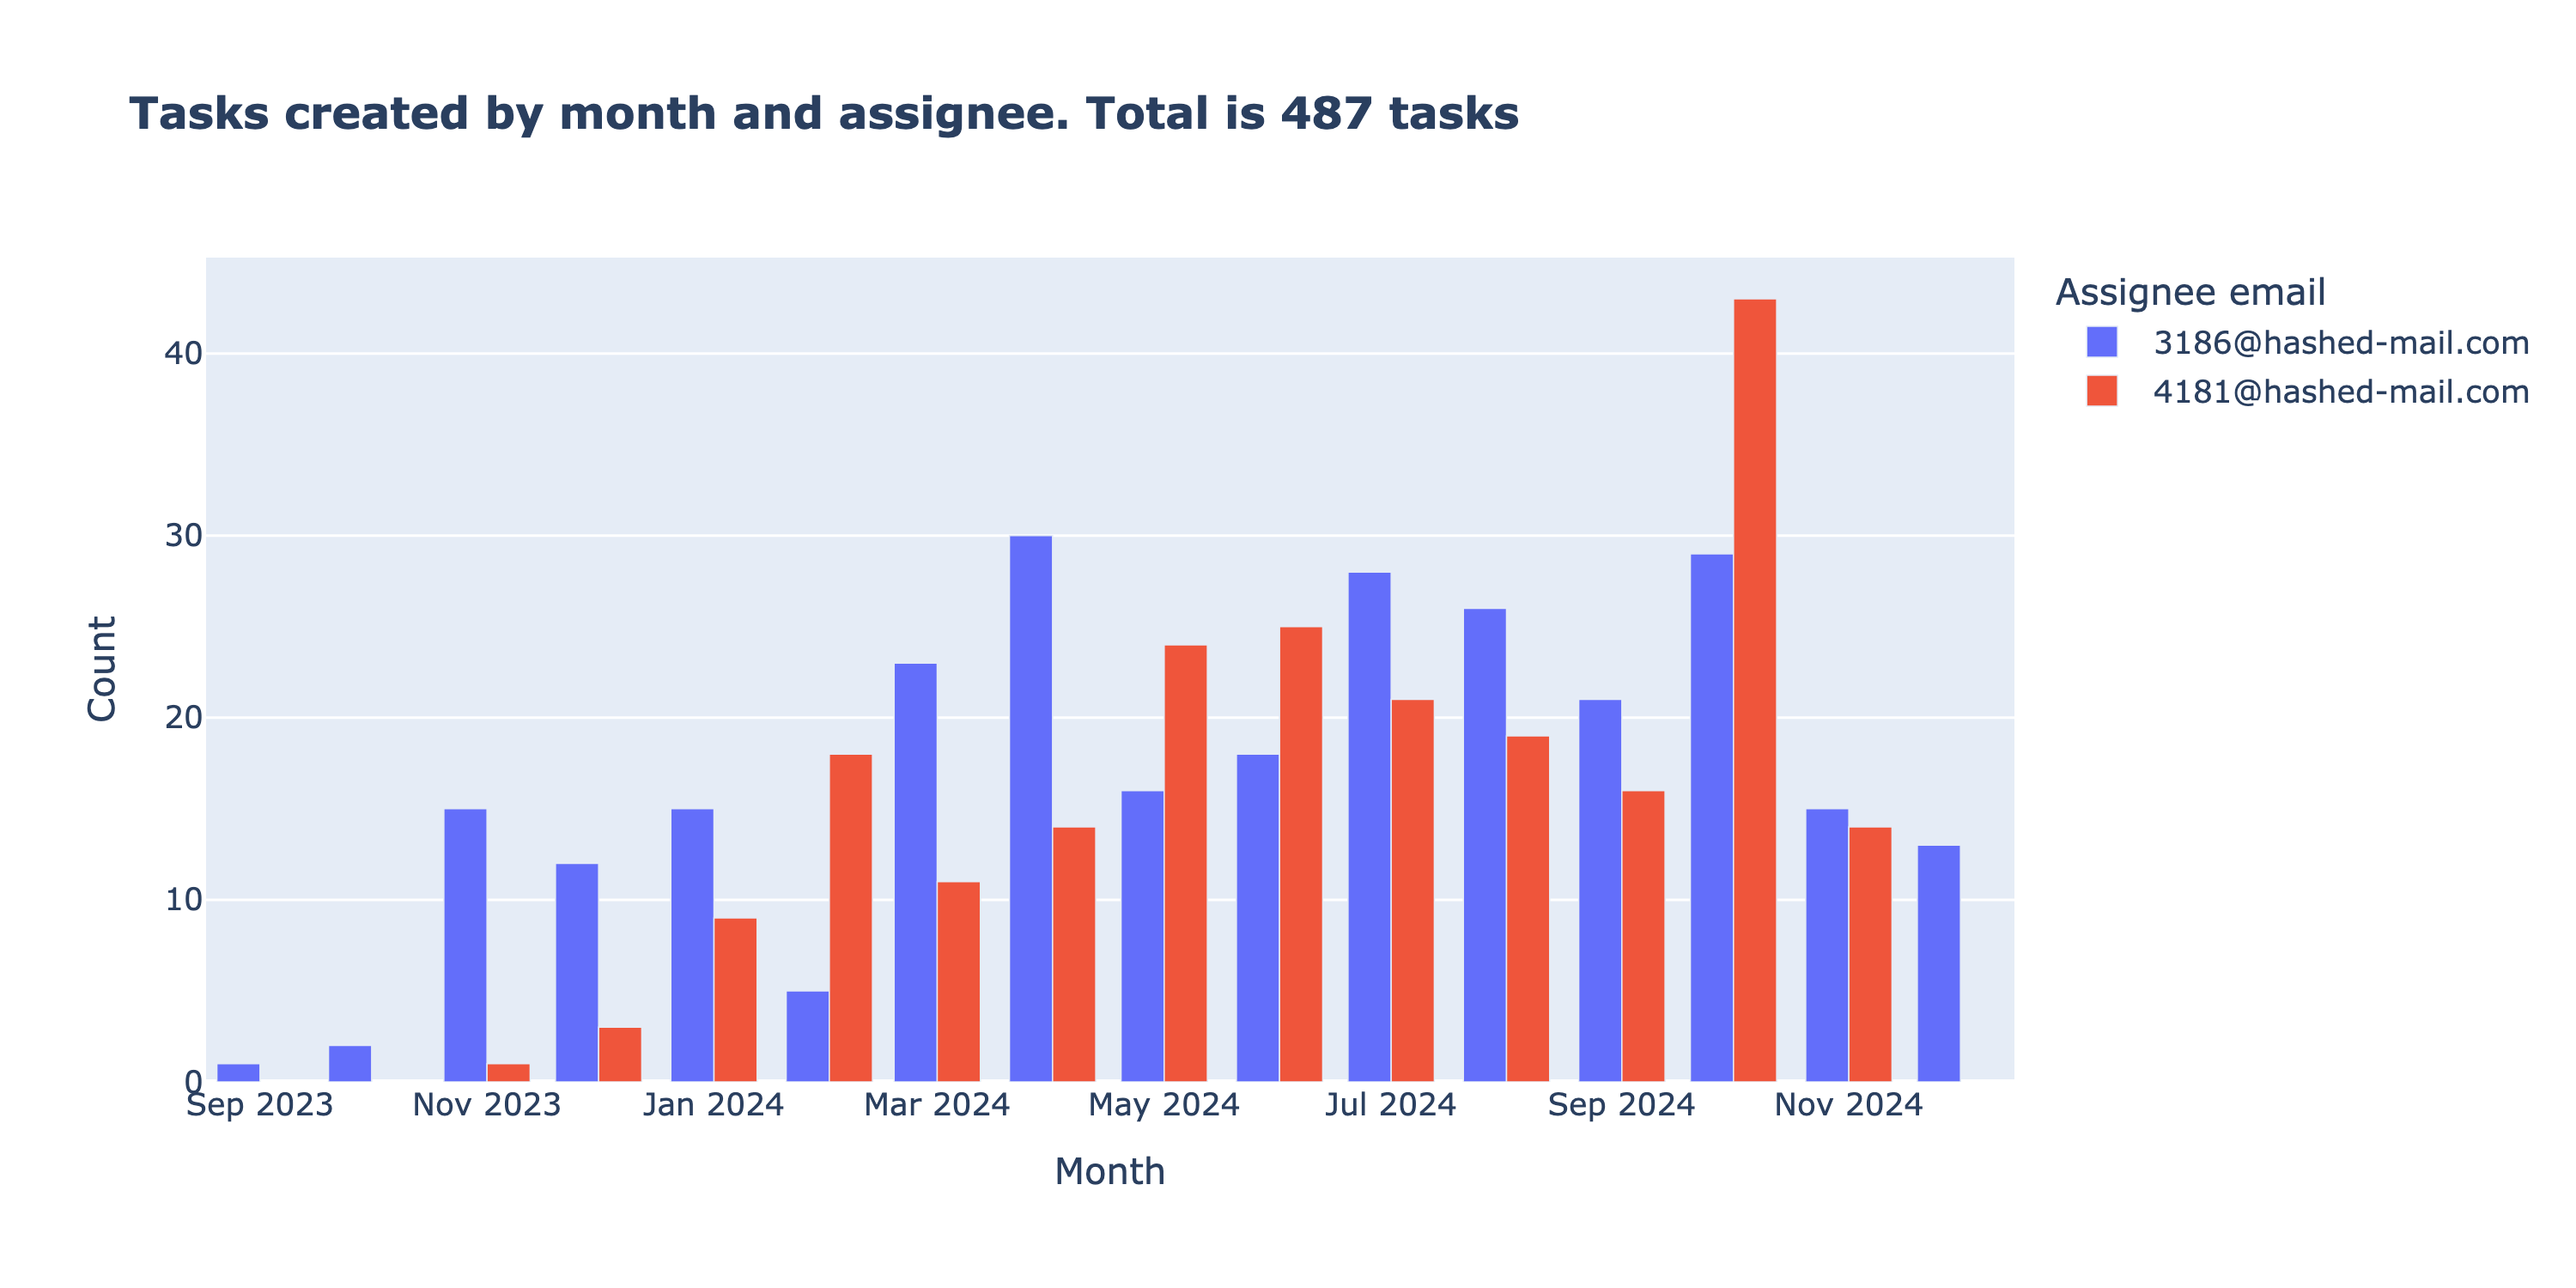

In [6]:

data["month"] = data.jira_created.dt.tz_localize(None).dt.to_period("M").dt.to_timestamp()
gdf = data.groupby(["month", "assignee_email"]).size().reset_index()
gdf.columns = ["month", "assignee_email", "count"]

px.bar(
    gdf,
    x="month",
    y="count",
    color="assignee_email",
    title=f"<b>Tasks created by month and assignee. Total is {data.shape[0]} tasks</b>",
    labels={"month": "Month", "count": "Count", "assignee_email": "Assignee email"},
    barmode="group",
).show(**vs)



Based on this chart and the previous one, we can infer a trend of underestimating the workload for team members. While the team provides feedback indicating a high workload, the charts reveal a decreasing trend in total workload, both in hours and tasks, over time.

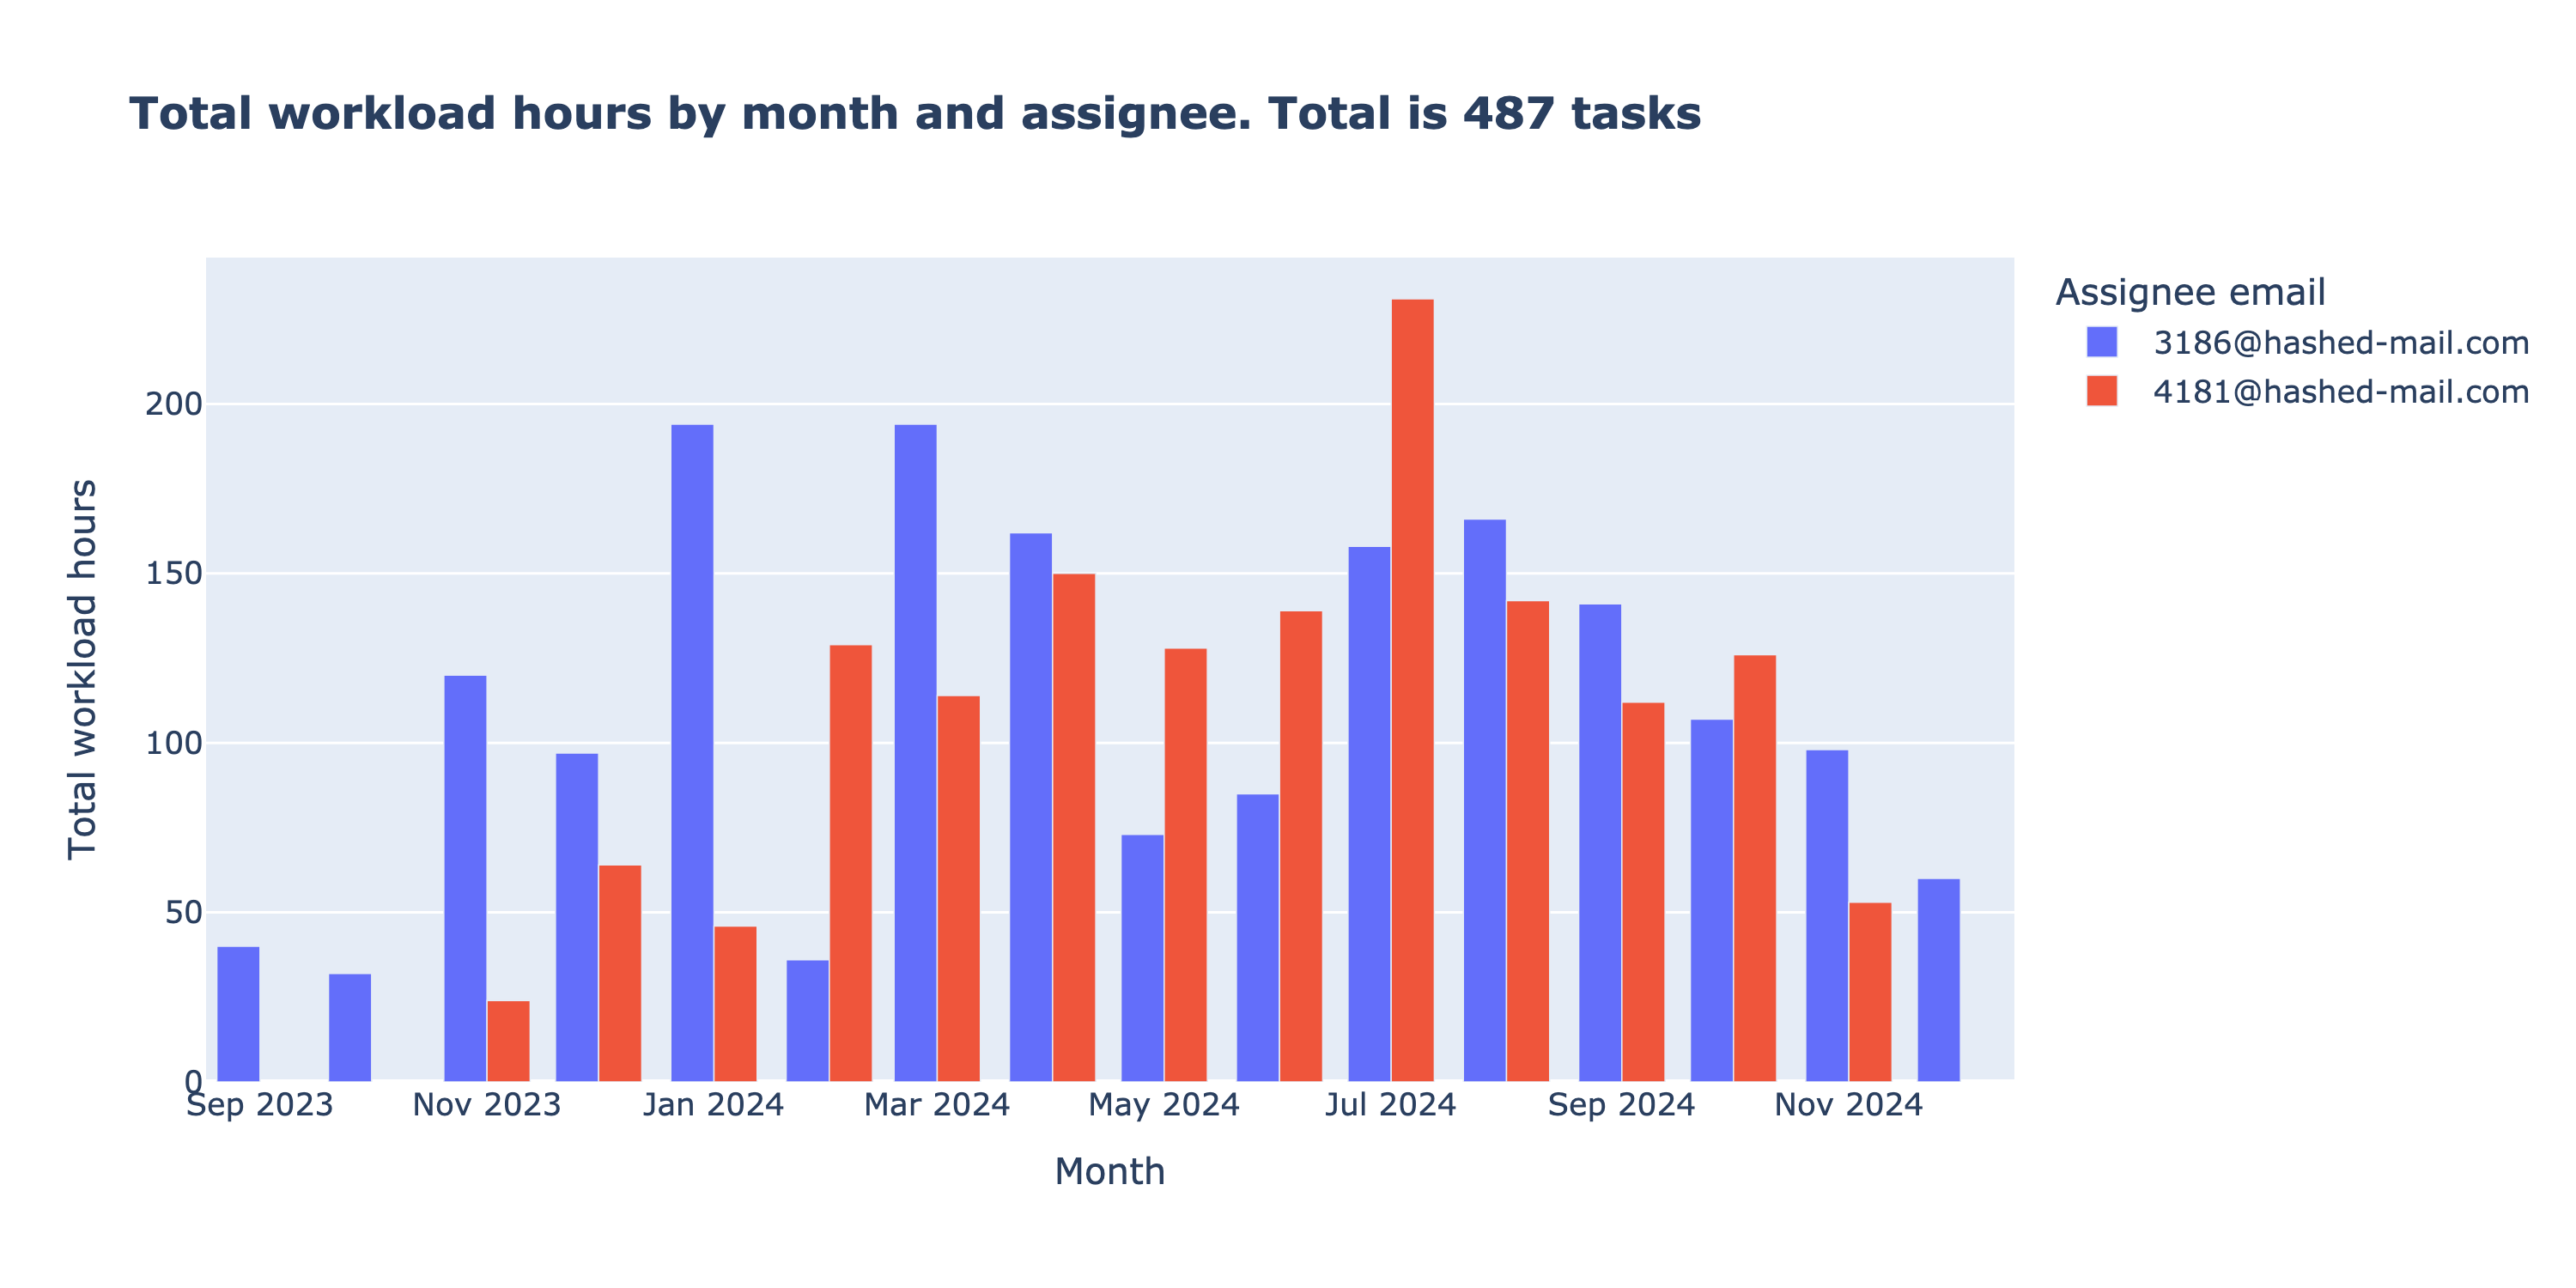

In [7]:
data["month"] = data.jira_created.dt.tz_localize(None).dt.to_period("M").dt.to_timestamp()
gdf = data.groupby(["month", "assignee_email"]).time_to_complete_hours.sum().reset_index()
gdf.columns = ["month", "assignee_email", "total_workload_hours"]

px.bar(
    gdf,
    x="month",
    y="total_workload_hours",
    color="assignee_email",
    title=f"<b>Total workload hours by month and assignee. Total is {data.shape[0]} tasks</b>",
    labels={"month": "Month", "total_workload_hours": "Total workload hours", "assignee_email": "Assignee email"},
    barmode="group",
).show(**vs)

# <b> Overview of jira task length

In [8]:
final_data.head(0)

,assignee_level_order,jira_key,weeks_since_member_join,time_to_complete_hours,task_text


In [9]:
final_data["task_text_length"] = final_data.task_text.apply(lambda _x: len(_x.split()))

The average task text length is 186 words. The standard deviation is 23 words.
The histogram shows that most tasks have a text length of 130 to 240 words.

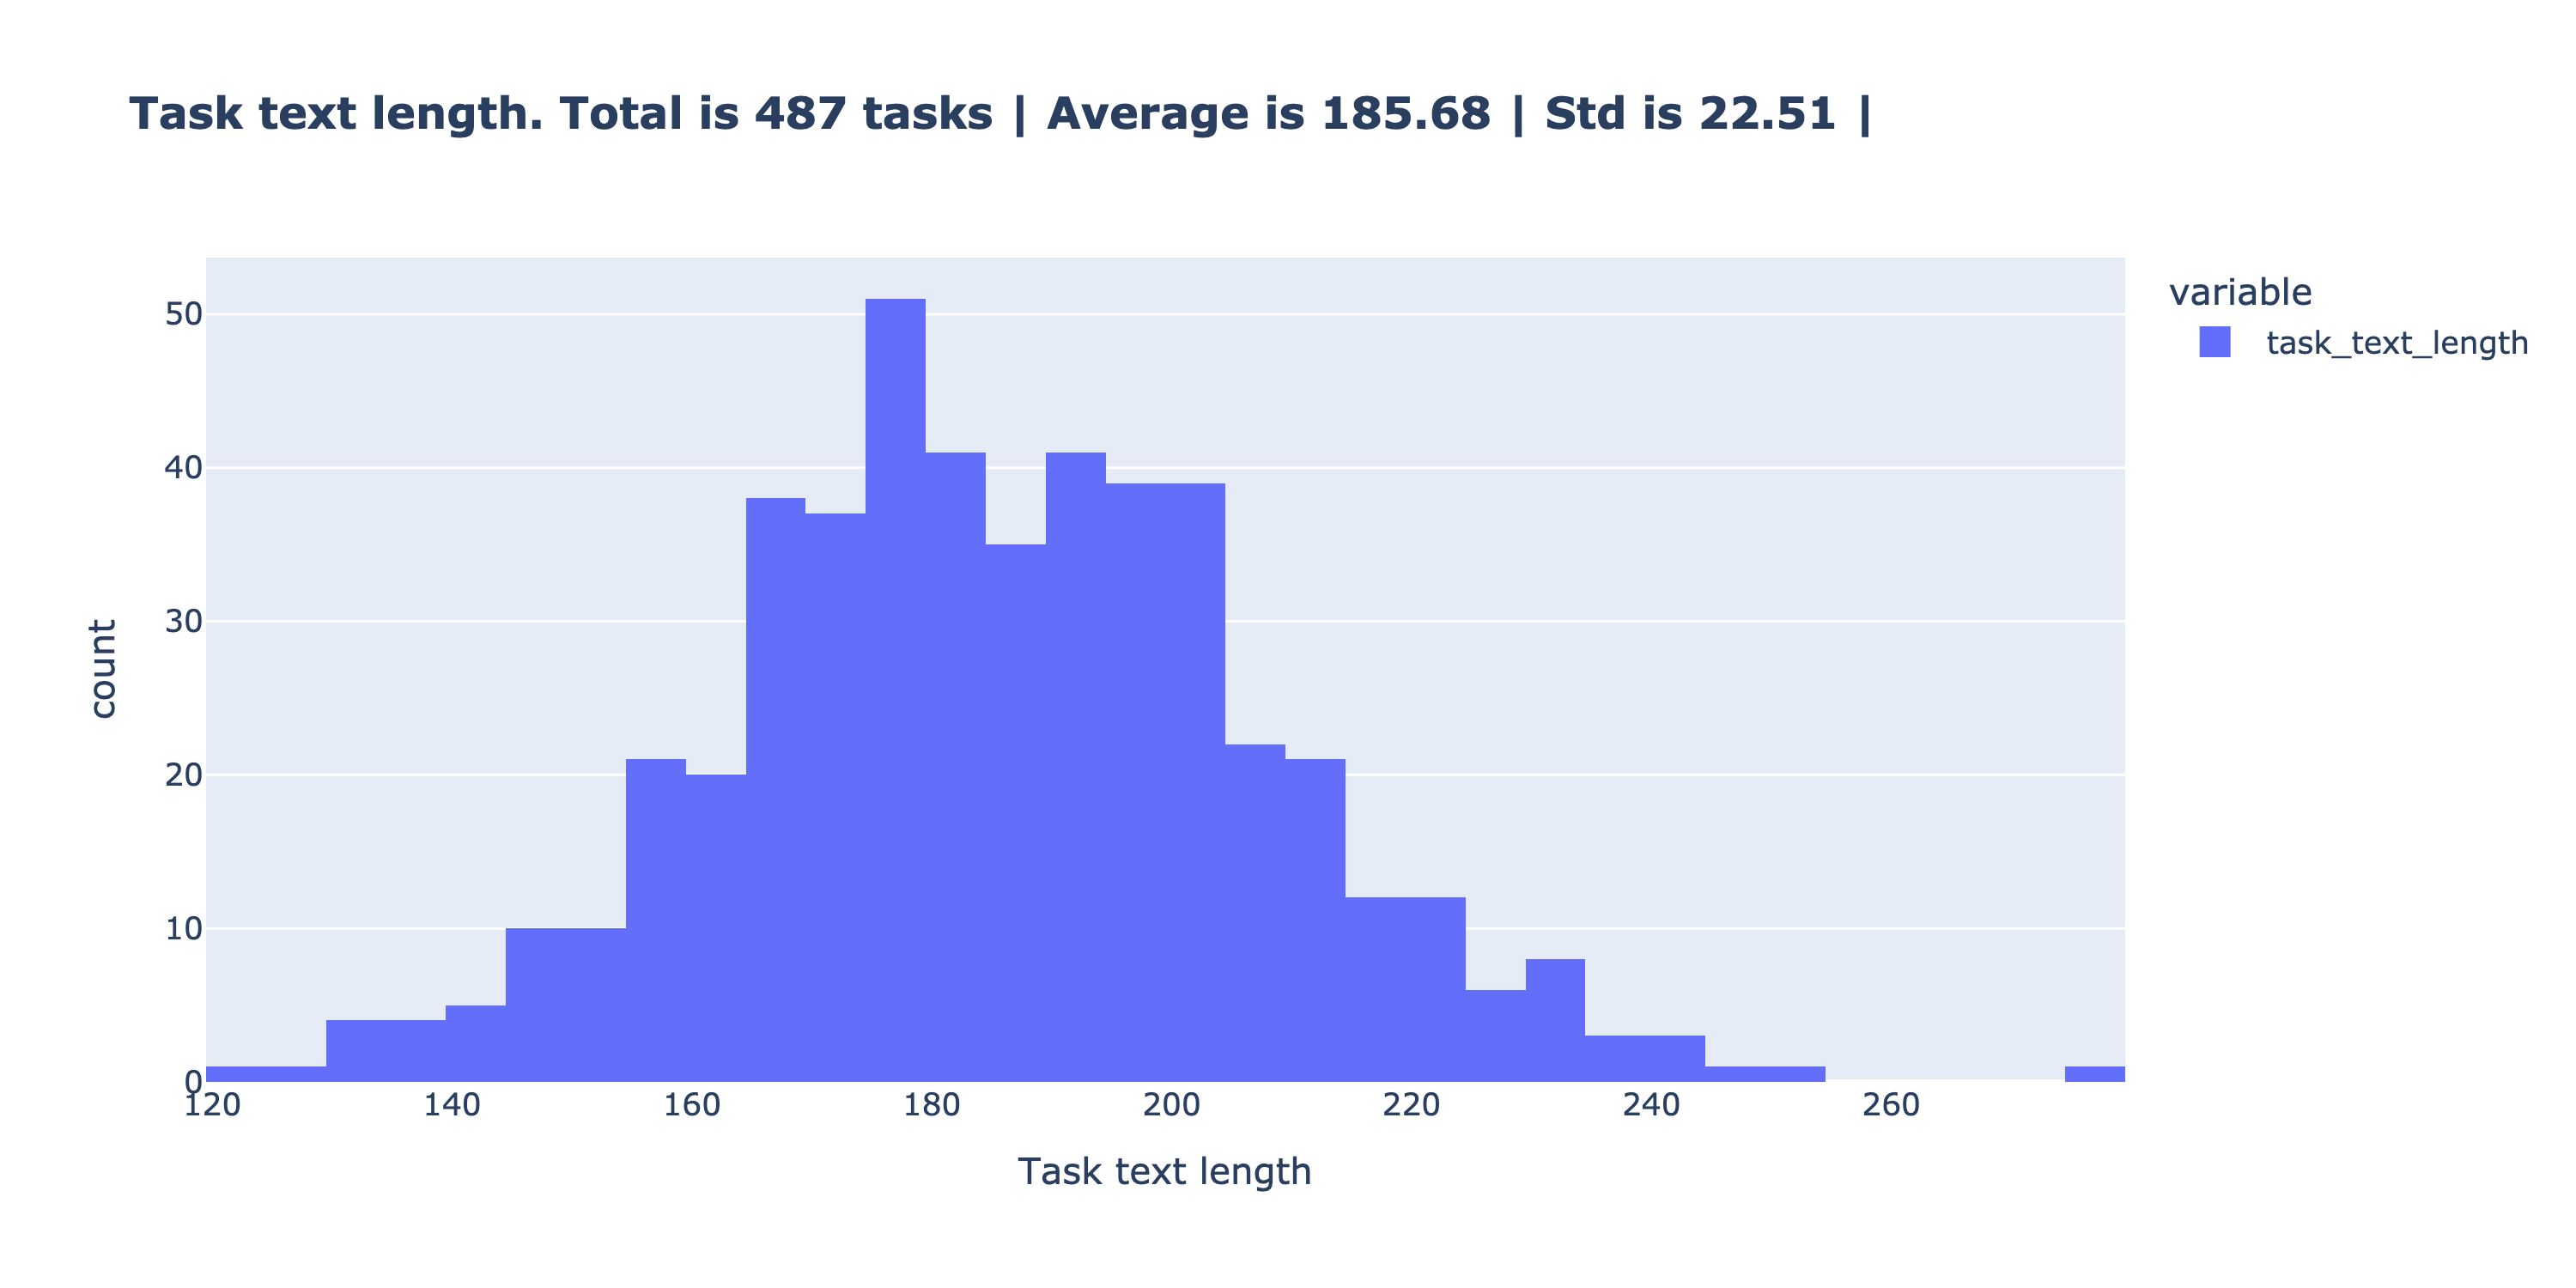

In [10]:

px.histogram(
    final_data.task_text_length,
    title=f"<b>Task text length. Total is {final_data.shape[0]} tasks | "
          f"Average is {final_data.task_text_length.mean():.2f} | "
          f"Std is {final_data.task_text_length.std():.2f} | ",
    labels={"value": "Task text length", "count": "Count"},
).show(**vs)

There are no significant trends in the relationship between task text length and time to complete.

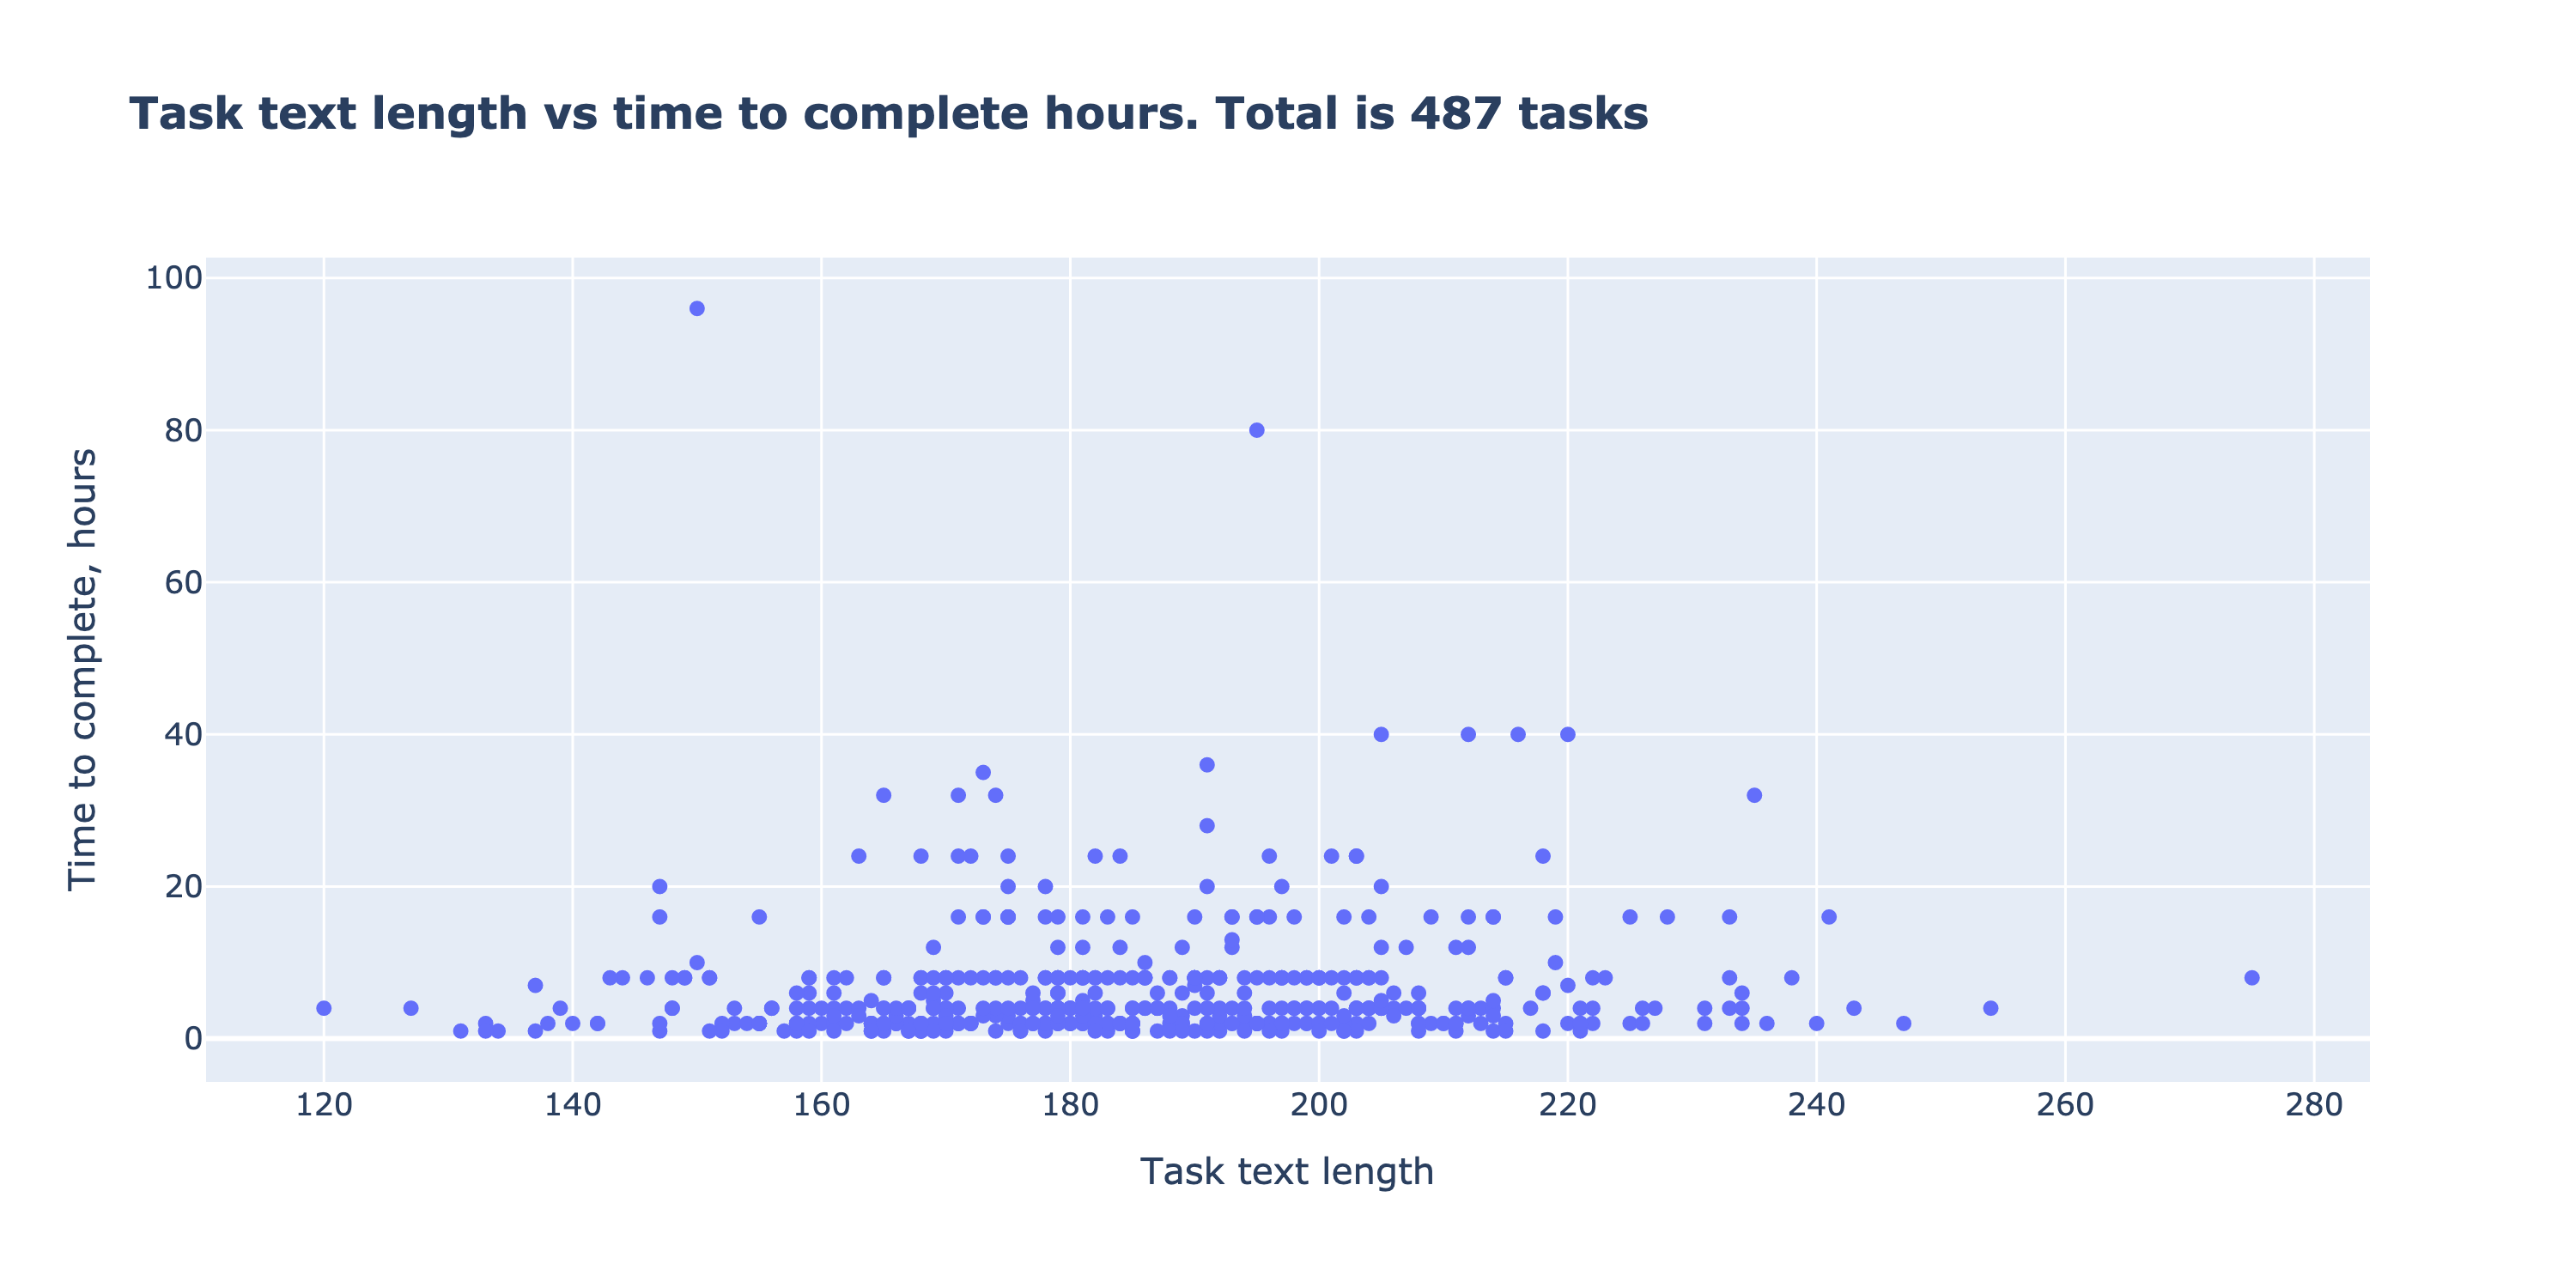

In [11]:
px.scatter(
    final_data,
    x="task_text_length",
    y="time_to_complete_hours",
    title=f"<b>Task text length vs time to complete hours. Total is {final_data.shape[0]} tasks</b>",
    labels={"task_text_length": "Task text length", "time_to_complete_hours": "Time to complete, hours"},
).show(**vs)

In [12]:
from src.data.combine_text_info_into_one_task import TaskSchema, TaskCreator

In [13]:
def get_raw_string_before_llm(item: pd.Series) -> str:
    task = TaskSchema(
        jira_title="" if pd.isna(item.jira_title) else item.jira_title,
        jira_description="" if pd.isna(item.jira_description) else item.jira_description,
        slack_messages="" if pd.isna(item.slack_thread_messages) else item.slack_thread_messages,
    )
    task_description = TaskCreator().combine_json_to_task(task)

    return task_description


data["task_description"] = data.apply(get_raw_string_before_llm, axis=1)

In [14]:
data["task_description_length"] = data.task_description.apply(lambda _x: len(_x.split()))

data = data.merge(final_data[["jira_key", "task_text_length"]], on="jira_key")

A lot of tasks have a description length of 4-9 words. This is an issue that needs to be addressed in the future. We cannot exclude this tasks because they are important.

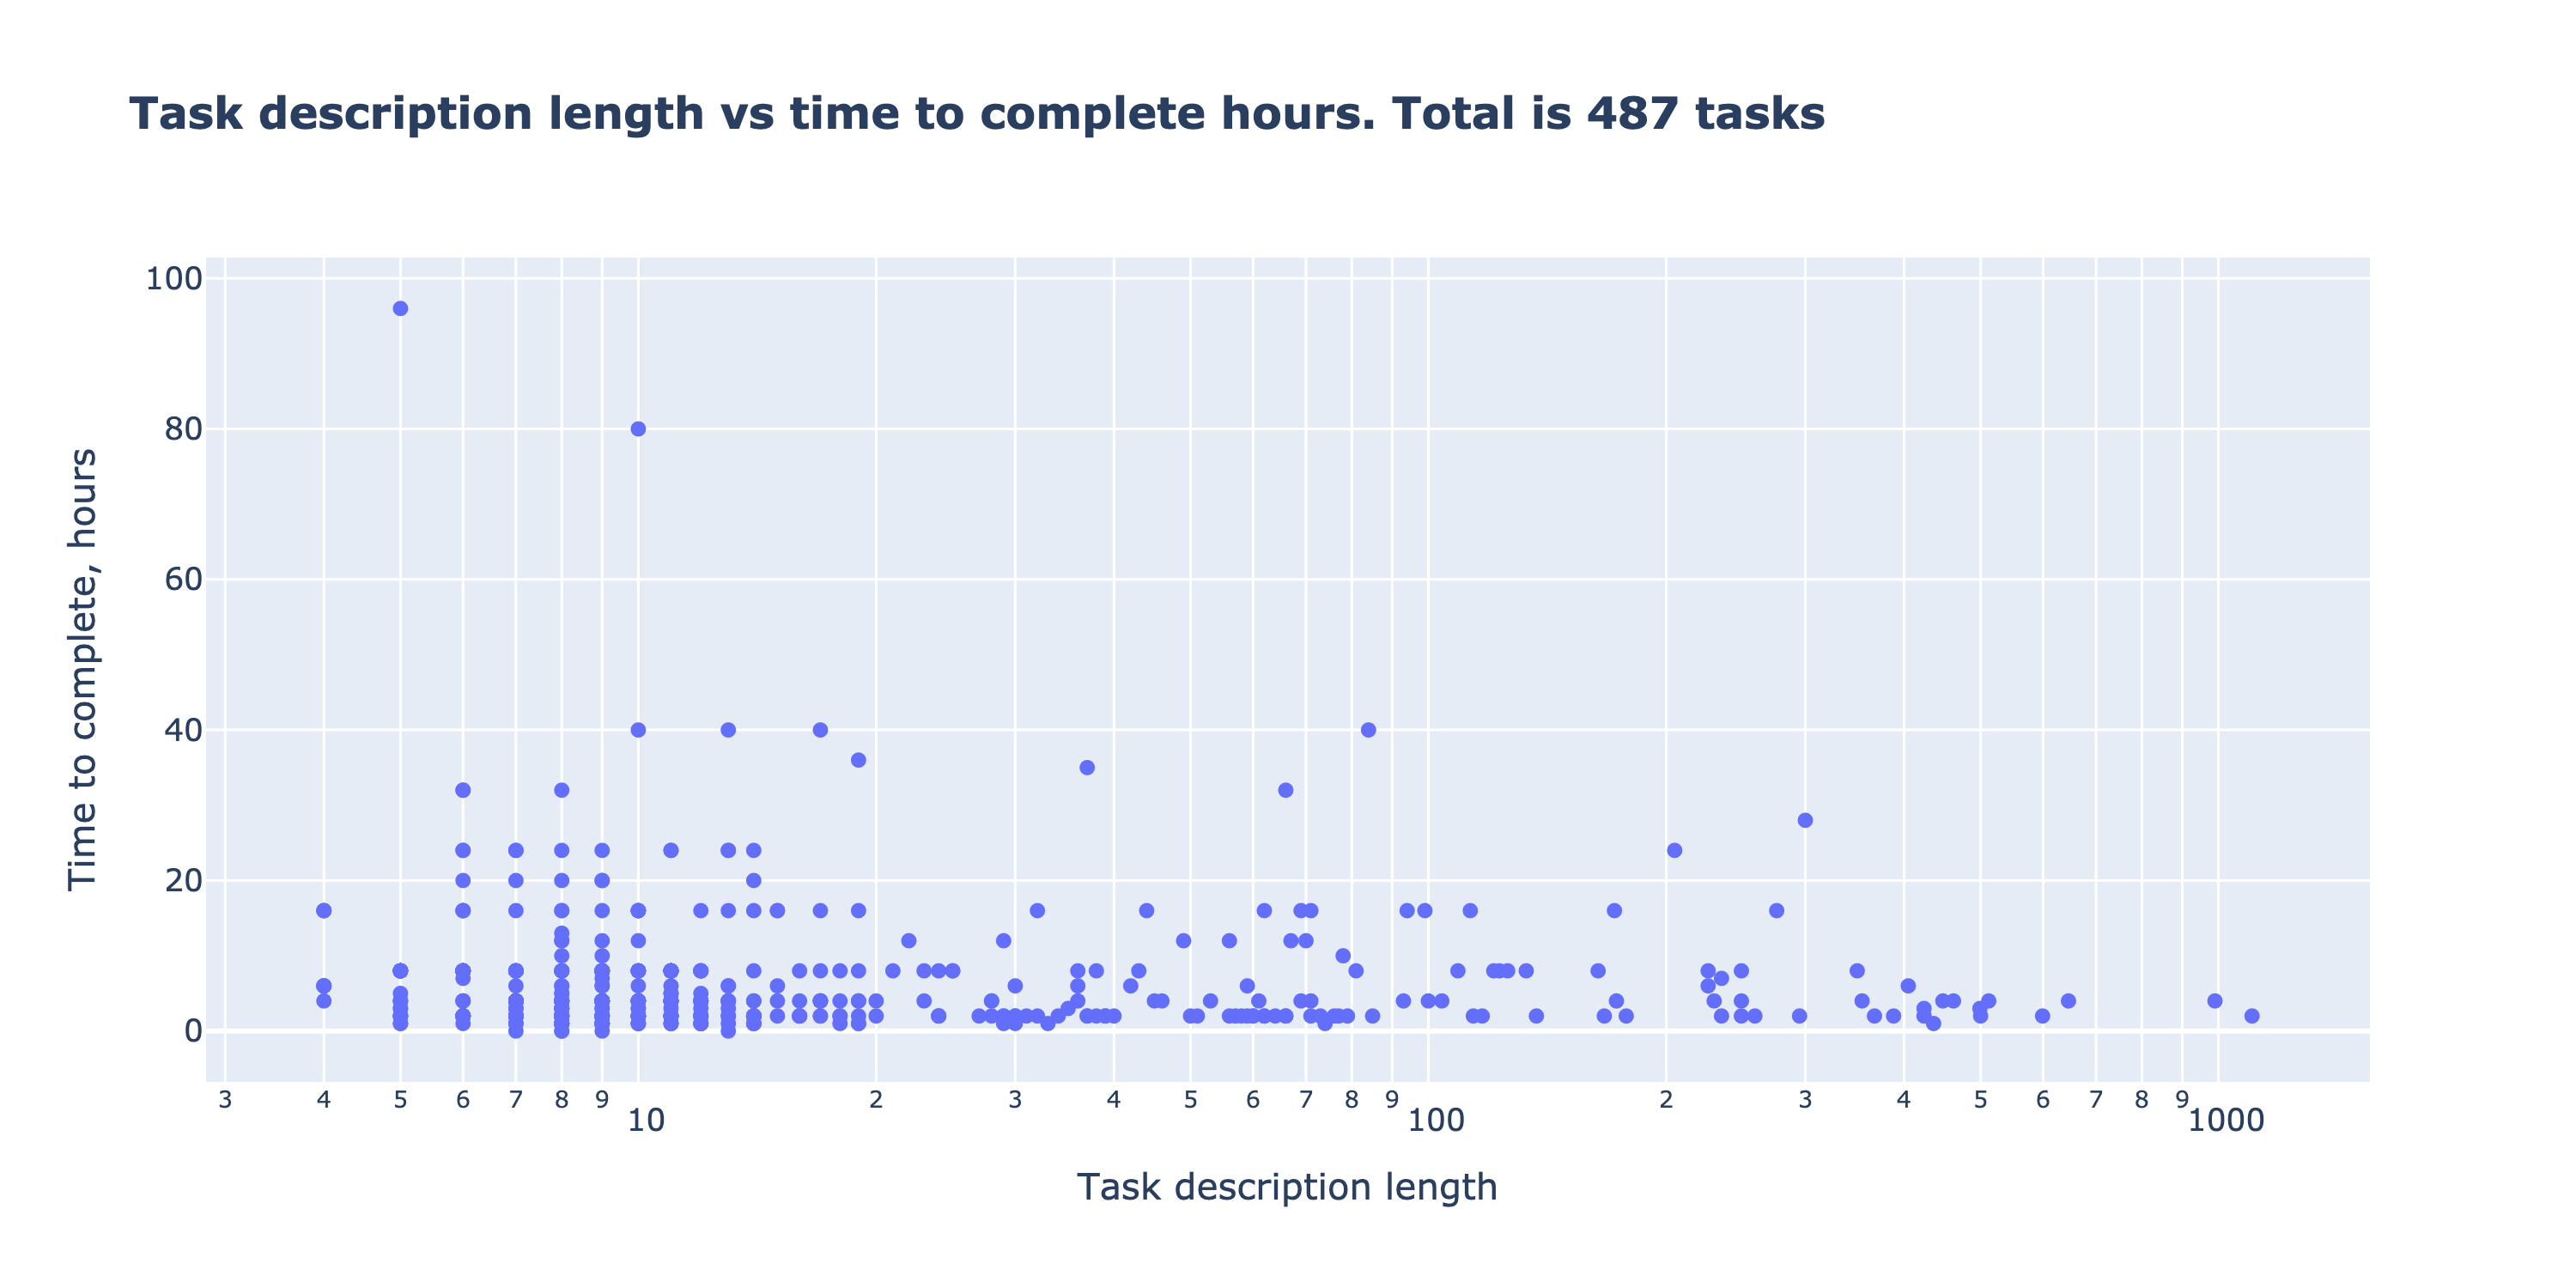

In [15]:
px.scatter(
    data,
    x="task_description_length",
    y="time_to_complete_hours",
    title=f"<b>Task description length vs time to complete hours. Total is {final_data.shape[0]} tasks</b>",
    labels={"task_description_length": "Task description length", "time_to_complete_hours": "Time to complete, hours"},
    log_x=True,
).show(**vs)

Cumulative distribution function for task text length shows that 50% of tasks have a text length of 10 words or fewer. ±70% of tasks have a text length of 20 words or fewer. 90% of tasks have a text length of 100 words or fewer. Only 10% of tasks have a text length of 100 words or more.

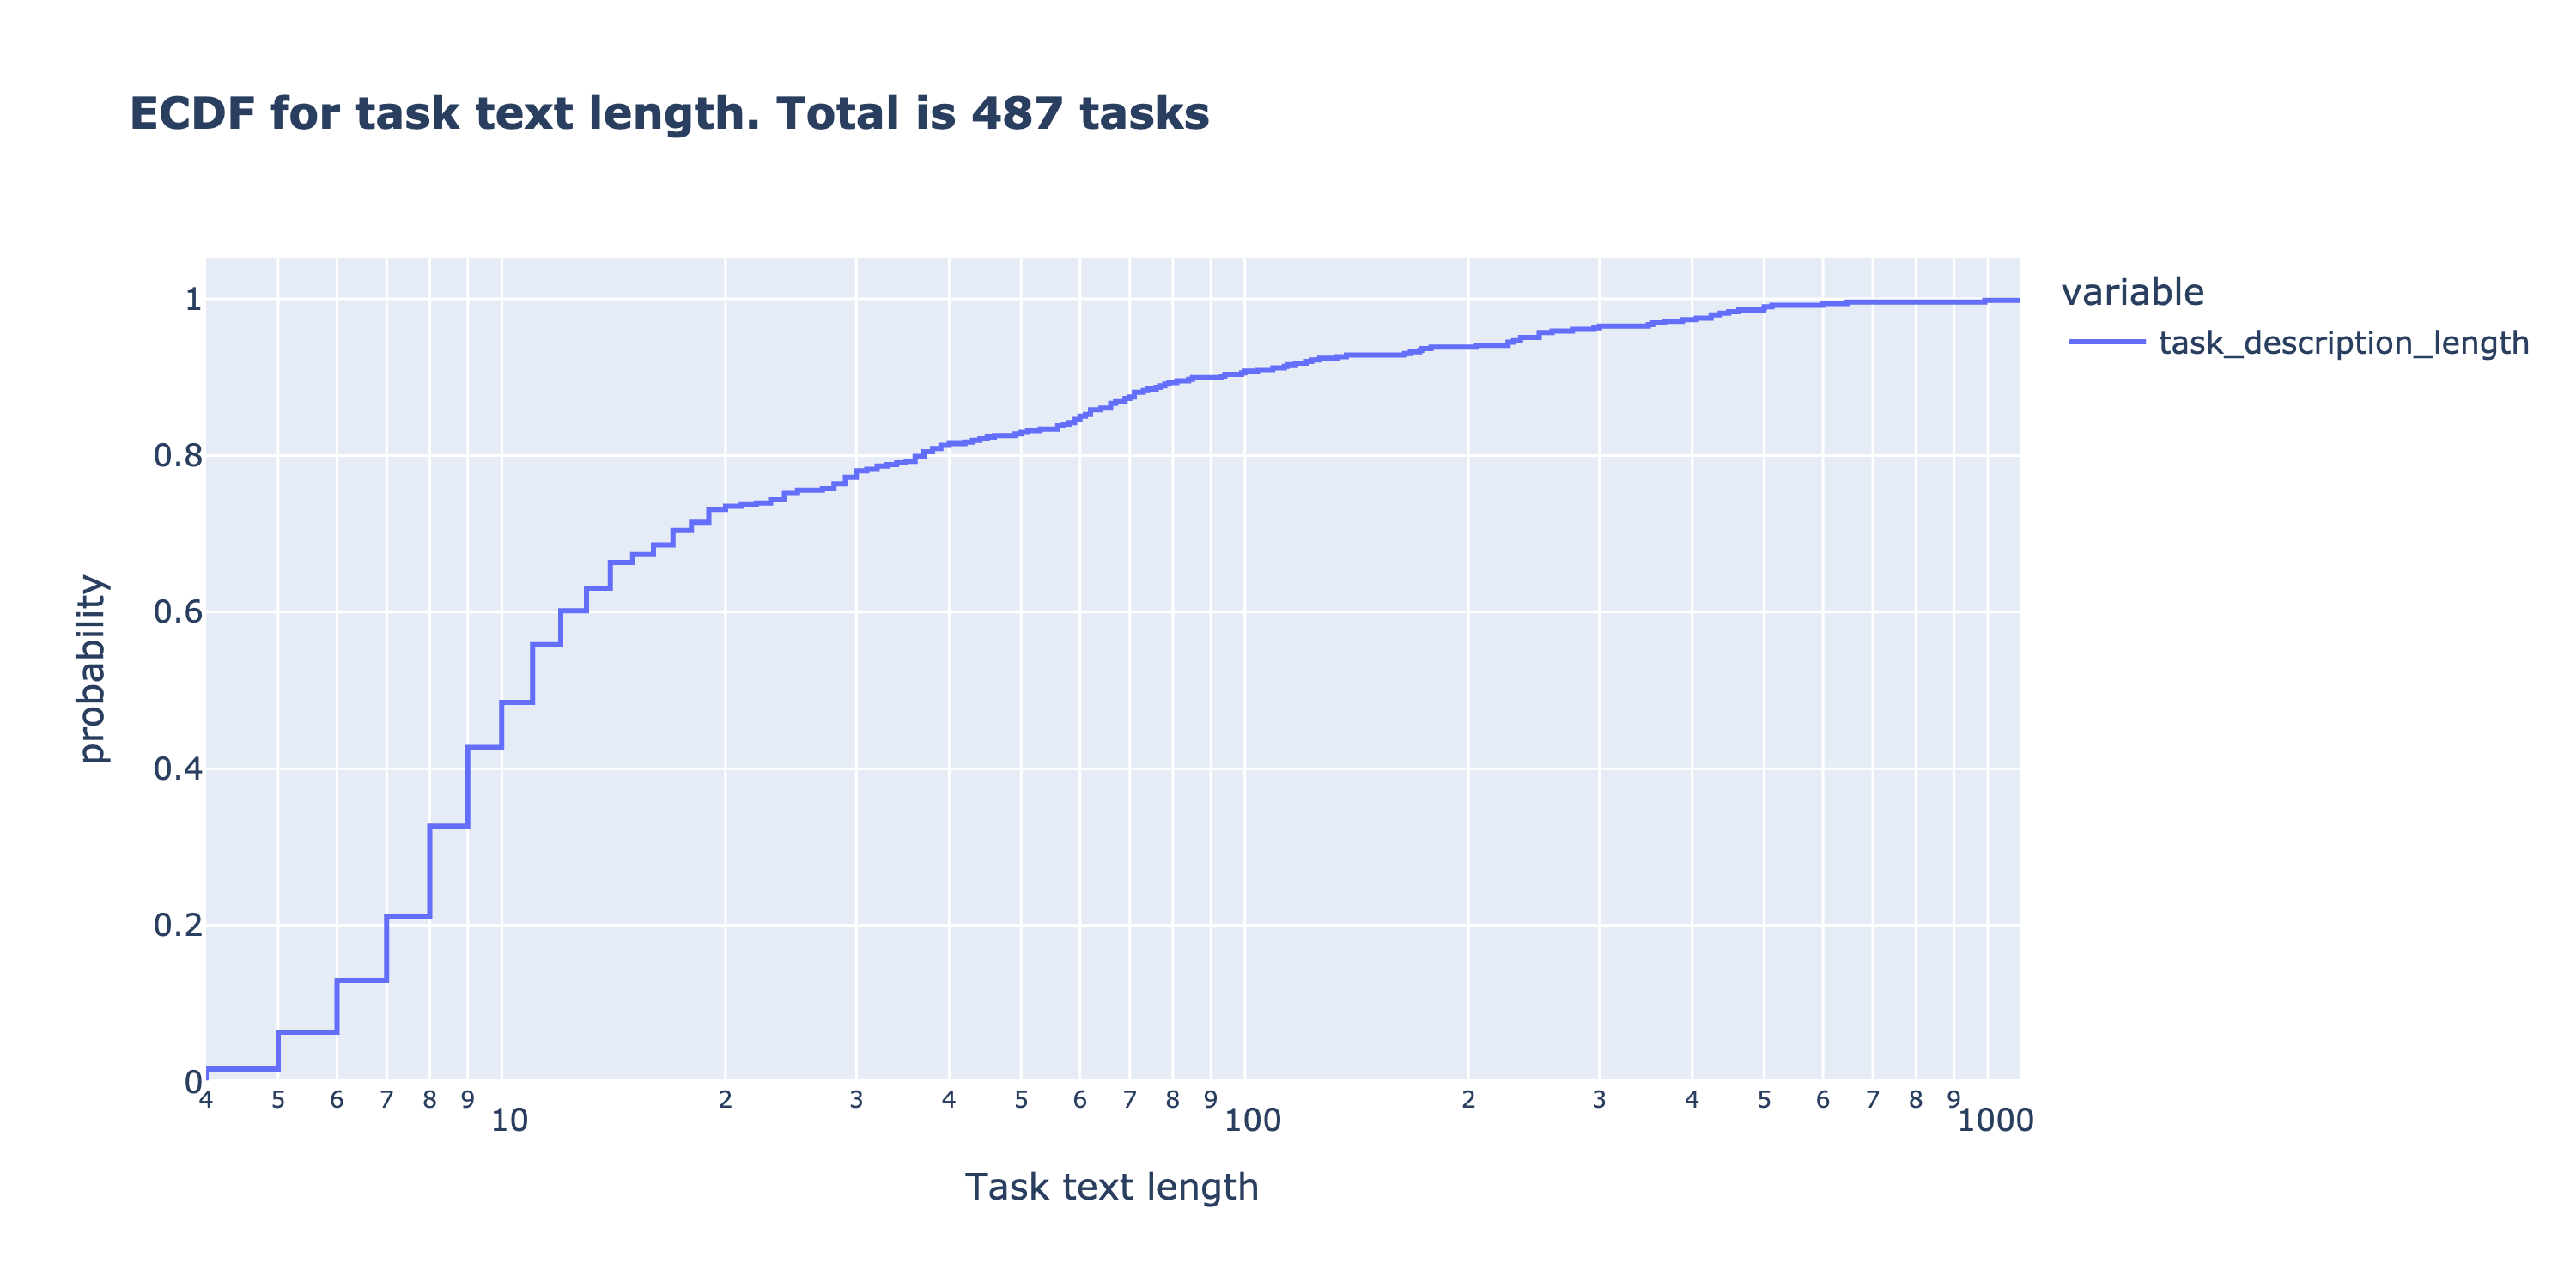

In [16]:
fig = px.ecdf(
    data.task_description_length,
    title=f"<b>ECDF for task text length. Total is {final_data.shape[0]} tasks</b>",
    labels={"value": "Task text length", "count": "Count"},
    log_x=True,
)

fig.show(**vs)

2d histogram between task_description (before LLM) and task_text (after LLM)
There are no strong correlations between these two features but moderate correlation about 34%

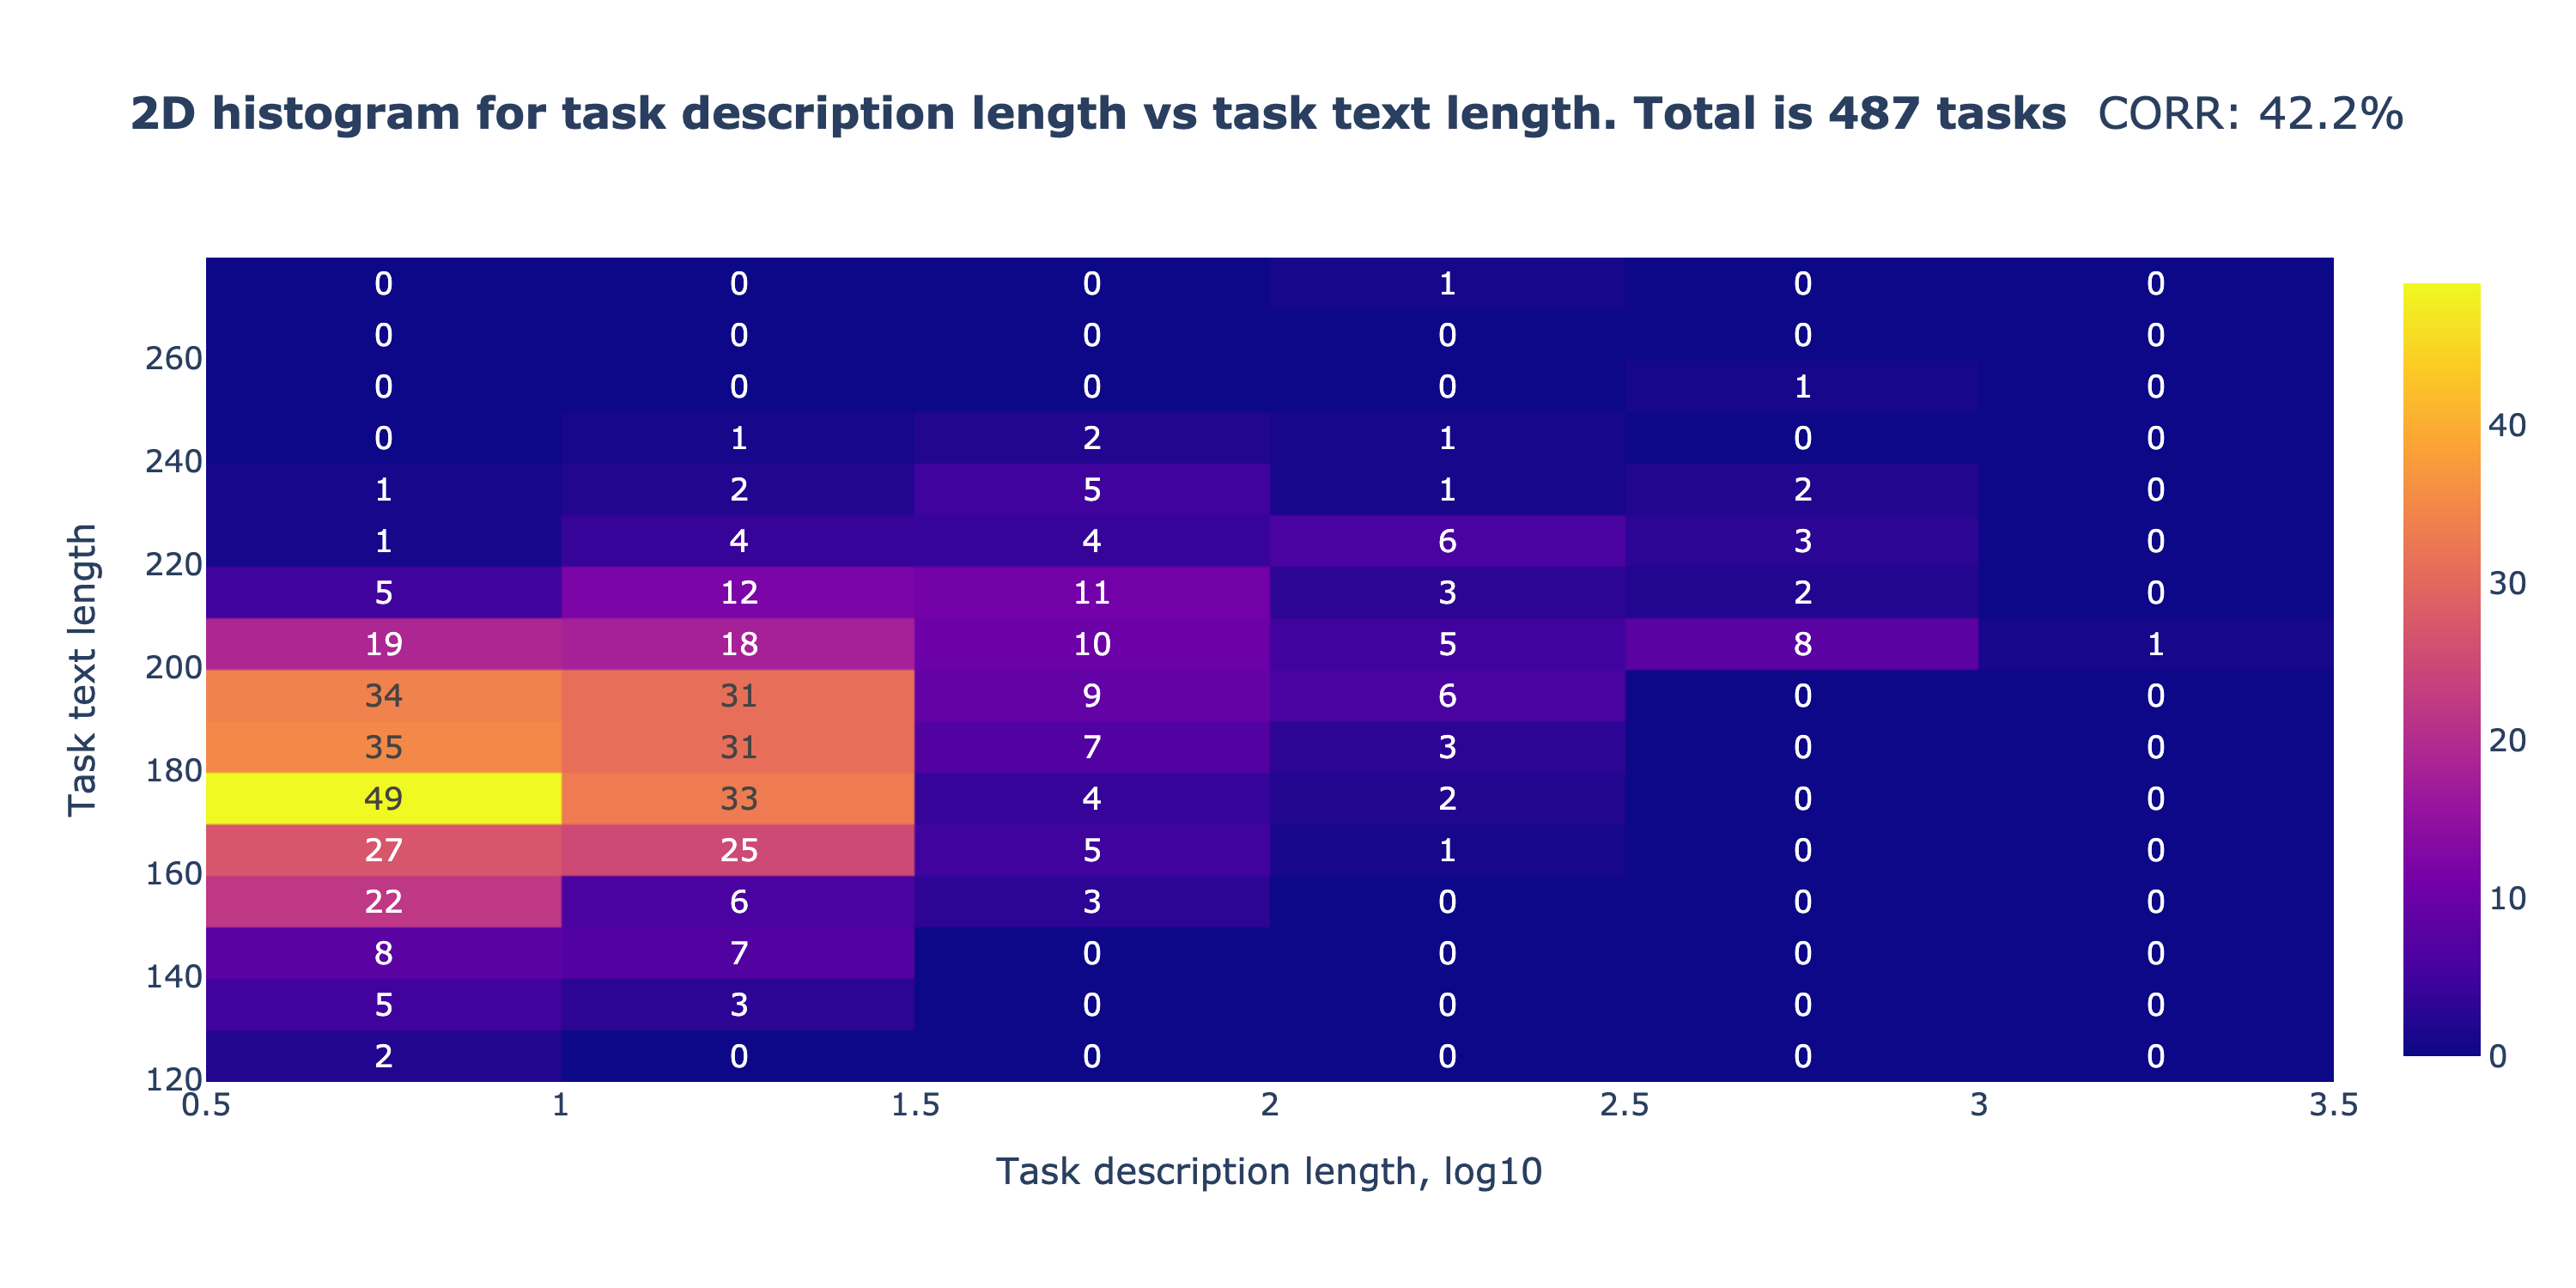

In [17]:
import plotly.graph_objs as go

data["task_description_length_ln"] = np.log10(data.task_description_length)

fig = go.Figure(go.Histogram2d(
    x=data.task_description_length_ln,
    y=data.task_text_length,
    texttemplate="%{z:.f}",
))

fig.update_layout(
    title=f"<b>2D histogram for task description length vs task text length. Total is {final_data.shape[0]} tasks</b>"
          f"\t CORR: {data[['task_description_length', 'task_text_length']].corr(method="spearman").iloc[0, 1]:.1%}",
    xaxis_title="Task description length, log10",
    yaxis_title="Task text length",
)

fig.show(**vs)

Simple approach to predict time to complete hours based on task text length and description length
We will use weighted accuracy as a metric
The model has a weighted accuracy of -13%.
Experts' estimations are more accurate than the model's predictions ~30%

In [18]:
from src.modeling.metrics import weighted_accuracy
import sklearn as sk

x = data[["task_text_length", "task_description_length"]]
y = data["time_to_complete_hours"]

x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size=0.2, random_state=config.random_state)

model = sk.linear_model.LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"{weighted_accuracy(y_test, y_pred):0.2%}")

-12.59%


# <b>Summary</b>

**Summary of Exploratory Data Analysis (EDA):**

1. **Overview of Data**:
   - The dataset contains enriched Jira task data, with key features such as `jira_created` (task creation date), `time_to_complete_hours`, and anonymized `assignee_email`, standardized text of task `task_text`.
   - Initial exploration highlighted that most tasks were resolved within 2 hours, with common completion times aligning with planning estimates (1, 2, 4, 8, and 16 hours).

2. **Task Completion Trends**:
   - Analysis of tasks created by month and assignee showed a correlation between team experience/tenure and task handling capacity.
   - A decreasing trend in total workload over time (both hours and task count) was observed, contrary to team feedback on workload perception.

3. **Task Description Analysis**:
   - Task descriptions (raw, pre-LLM) had a substantial number of short entries (4–9 words), highlighting a potential issue in data completeness.
   - Cumulative Distribution Function (ECDF) showed that 50% of tasks have descriptions of 10 words or fewer, and 90% have descriptions of 100 words or fewer.

4. **Standardized Task Text Analysis**:
   - The average task text length is approximately 186 words (standard deviation: 23 words).
   - Histogram analysis revealed that most task texts ranged between 130 and 240 words.
   - Scatter plots indicated no significant trends between task text length and time to complete.

5. **Correlations Between Task Features**:
   - Moderate correlation (~34%) between raw task description length and post-LLM task text length was observed via a 2D histogram.

6. **Prediction Model**:
   - A simple regression model predicting `time_to_complete_hours` based on `task_text_length` and `task_description_length` yielded a weighted accuracy of -13%.
   - Expert estimations (~30% accuracy) significantly outperformed the model, underscoring the need for better feature engineering and model selection.

7. **Key Insights and Recommendations**:
   - In order to improve data quality and prediction accuracy, the abandonment of short task descriptions should be considered.
   - Despite perceived high workloads, actual workload trends (as per data) are decreasing.
   - Enhanced modeling techniques and additional predictive features are required to improve time estimation accuracy.

## <b>Summary for task</b>

1. **Data Assessment:**
   The dataset was evaluated to determine its composition, volume, and quality. Out of an initial pool of **800+ tasks**, a subset of **487 tasks** was selected for analysis. Each task includes a Jira title, description, and occasionally Slack messages.
   - **Key Findings:**
     - 50% of tasks have descriptions of **10 words or fewer**.
     - 90% of tasks have descriptions of **100 words or fewer**.
   These findings indicate a lower quality of data, which may impact subsequent analysis and model performance. Despite these limitations, the dataset was used for initial model testing to gauge its potential.

2. **Visualizations and Insights:**
   Relevant visualizations were created to explore the dataset and extract key insights. Summaries of these findings have been provided in the corresponding section above.

3. **Deliverables:**
   The exploratory data analysis (EDA) has been documented in the notebook located at:
   `notebooks/eda.ipynb`. All outputs, including notebooks, reports, and dataset links, have been added to the appropriate folders in the repository.

